In [34]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.decomposition import PCA

## Feature Extraction

### Local Binary Pattern

In [35]:
def read_images_from_folder(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder  # Use the subfolder name as the label
            for fn in os.listdir(subfolder_path):
                if fn.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, fn)
                    im = Image.open(img_path).convert('L')
                    data = np.array(im)
                    images.append(data)
                    labels.append(label)

    return images, labels

# Load images and labels from the 'resize_data' 
data_folder = './resize_data'
images, labels = read_images_from_folder(data_folder)
print('Load data success!')

X = np.array(images)
print(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

radius = 2
n_point = radius * 8

Load data success!
(1790, 256, 256)
(1432, 256, 256)
(358, 256, 256)
(1432,)
(358,)


In [36]:
def lbp_texture(train_data, test_data):
    max_bins_train = 0
    max_bins_test = 0

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        max_bins_train = max(max_bins_train, int(lbp.max()) + 1)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        max_bins_test = max(max_bins_test, int(lbp.max()) + 1)

    train_hist = np.zeros((len(train_data), max_bins_train))
    test_hist = np.zeros((len(test_data), max_bins_test))

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        train_hist[i], _ = np.histogram(lbp, bins=max_bins_train, density=True)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        test_hist[i], _ = np.histogram(lbp, bins=max_bins_test, density=True)

    return train_hist, test_hist


In [37]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

KeyboardInterrupt: 

In [ ]:
# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

MLP model saved as ./model/mlp_lbp_model.pkl


### Convolutional Neural Network

In [44]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

In [61]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['accuracy']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)


In [62]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [63]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (128,128),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

In [64]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_generator,
    val_datagen, val_generator,
    test_datagen, val_generator)

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not DirectoryIterator

In [67]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 20,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.


Found 536 images belonging to 2 classes.
Epoch 1/20
40/40 [==============================] - 59s 1s/step - loss: 0.6346 - accuracy: 0.6396 - val_loss: 0.5864 - val_accuracy: 0.6866
Epoch 2/20
40/40 [==============================] - 57s 1s/step - loss: 0.5695 - accuracy: 0.7097 - val_loss: 0.5548 - val_accuracy: 0.7034
Epoch 3/20
40/40 [==============================] - 57s 1s/step - loss: 0.5093 - accuracy: 0.7608 - val_loss: 0.4985 - val_accuracy: 0.7799
Epoch 4/20
40/40 [==============================] - 56s 1s/step - loss: 0.4703 - accuracy: 0.7839 - val_loss: 0.4795 - val_accuracy: 0.7817
Epoch 5/20
40/40 [==============================] - 57s 1s/step - loss: 0.4611 - accuracy: 0.7895 - val_loss: 0.4704 - val_accuracy: 0.7873
Epoch 6/20
40/40 [==============================] - 57s 1s/step - loss: 0.4545 - accuracy: 0.7998 - val_loss: 0.4944 - val_accuracy: 0.7705
Epoch 7/20
40/40 [==============================] - 58s 1s/step - loss: 0.4308 - accuracy: 0.8174 - val_loss: 0.4787 - 

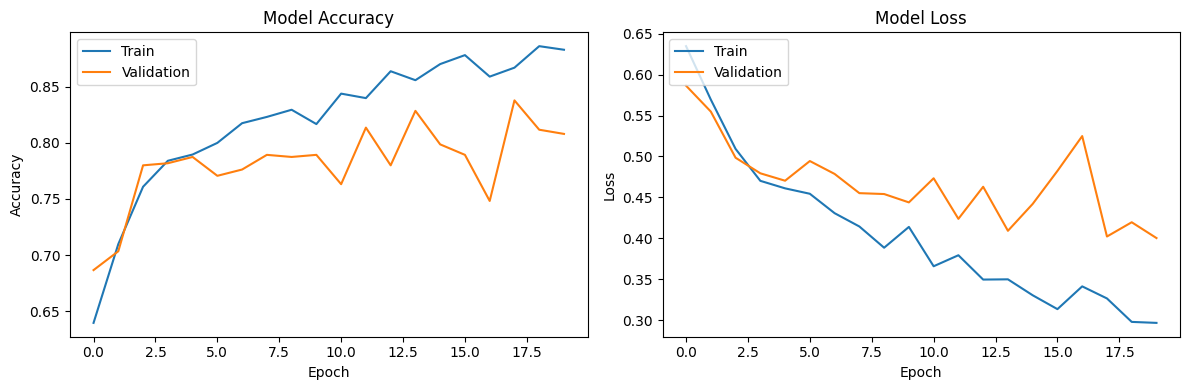

In [68]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [69]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# CNN model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
        
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizer.Adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 20,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.


Found 536 images belonging to 2 classes.
Epoch 1/20
40/40 [==============================] - 93s 2s/step - loss: 0.6879 - accuracy: 0.5391 - val_loss: 0.6677 - val_accuracy: 0.6418
Epoch 2/20
40/40 [==============================] - 91s 2s/step - loss: 0.6094 - accuracy: 0.6970 - val_loss: 0.6275 - val_accuracy: 0.6698
Epoch 3/20
40/40 [==============================] - 96s 2s/step - loss: 0.5817 - accuracy: 0.7161 - val_loss: 0.6125 - val_accuracy: 0.6810
Epoch 4/20
40/40 [==============================] - 95s 2s/step - loss: 0.5585 - accuracy: 0.7504 - val_loss: 0.5850 - val_accuracy: 0.7313
Epoch 5/20
40/40 [==============================] - 94s 2s/step - loss: 0.5107 - accuracy: 0.7743 - val_loss: 0.5606 - val_accuracy: 0.7500
Epoch 6/20
40/40 [==============================] - 93s 2s/step - loss: 0.5020 - accuracy: 0.7711 - val_loss: 0.5623 - val_accuracy: 0.7388
Epoch 7/20
40/40 [==============================] - 94s 2s/step - loss: 0.4824 - accuracy: 0.7879 - val_loss: 0.5621 - 

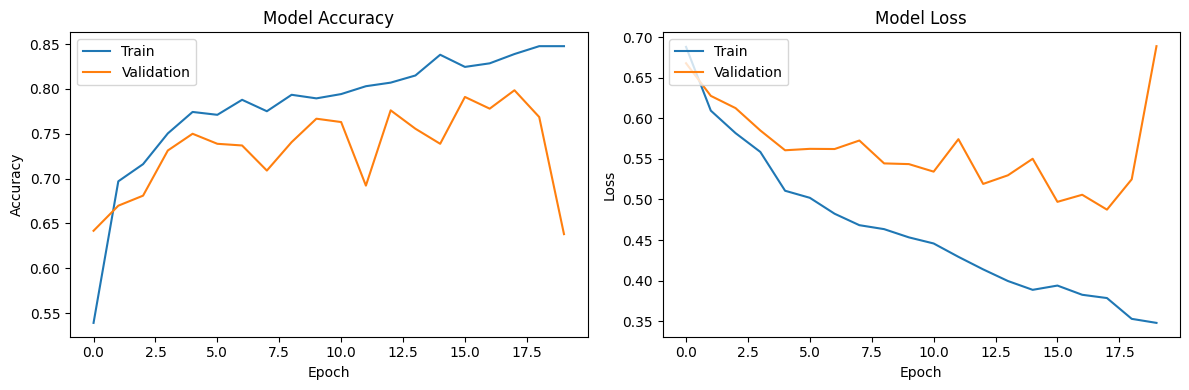

In [70]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [71]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode = 'rgb',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode = 'rgb',
    subset='validation',
    seed=42
)

# CNN model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
        
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 20,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.
Found 536 images belonging to 2 classes.
Epoch 1/20
40/40 [==============================] - 94s 2s/step - loss: 0.7052 - accuracy: 0.4585 - val_loss: 0.6968 - val_accuracy: 0.4608
Epoch 2/20
40/40 [==============================] - 94s 2s/step - loss: 0.7019 - accuracy: 0.4609 - val_loss: 0.6956 - val_accuracy: 0.4608
Epoch 3/20
40/40 [==============================] - 91s 2s/step - loss: 0.6979 - accuracy: 0.4665 - val_loss: 0.6952 - val_accuracy: 0.4608
Epoch 4/20
40/40 [==============================] - 90s 2s/step - loss: 0.6999 - accuracy: 0.4577 - val_loss: 0.6949 - val_accuracy: 0.4608
Epoch 5/20
40/40 [==============================] - 88s 2s/step - loss: 0.6979 - accuracy: 0.4689 - val_loss: 0.6941 - val_accuracy: 0.4590
Epoch 6/20
40/40 [==============================] - 90s 2s/step - loss: 0.6974 - accuracy: 0.4737 - val_loss: 0.6941 - val_accuracy: 0.4664
Epoch 7/20
40/40 [==============================] - 91s 2s/step - loss: 0.697

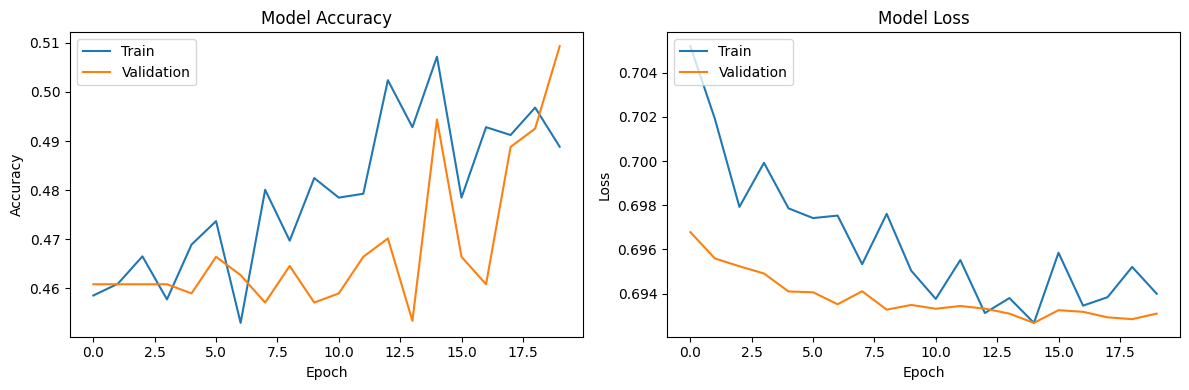

In [72]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()